In [1]:
%matplotlib inline
import cPickle as pkl
import pandas as pd
import numpy as np
import os,sys
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
dataset = pkl.load(open('dataset.pkl', 'rb'))

In [12]:
bots = [u for u in dataset.keys() if "-bot" == str(u)[-4:]]

In [13]:
from hmmlearn import hmm

In [14]:
hmmdata = [dataset[u] for u in dataset.keys() if "bot" not in str(u)]

In [15]:
hmmdata = [h for h in hmmdata if 150 > len(h) and len(h) > 30]

In [16]:
from random import sample
sample_size = 3000
hmmdata = sample(hmmdata, sample_size)

802

In [17]:
lens = [len(h) for h in hmmdata]

In [18]:
hmmdata = [[h for h in x] for x in hmmdata]

In [19]:
X = np.concatenate(hmmdata)

In [21]:
print set(list(X))

set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])


In [113]:
# from sklearn.preprocessing import LabelEncoder
# v = LabelEncoder()
# v.fit(X)

LabelEncoder()

In [149]:
# X = []
# for h in hmmdata:
#     X.append(v.transform(h))

ValueError: y contains new labels: [1]

In [22]:
n_components = 5

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
n_components = 4
model = hmm.MultinomialHMM(n_components=n_components, n_iter=40, algorithm='viterbi')

In [25]:
model.fit(np.atleast_2d(X).T,lens)

MultinomialHMM(algorithm='viterbi', init_params='ste', n_components=5,
        n_iter=10, params='ste',
        random_state=<mtrand.RandomState object at 0x104d31dc0>,
        startprob_prior=1.0, tol=0.01, transmat_prior=1.0, verbose=False)

In [26]:
label_encodings = ['MemberEvent_same',
 'PublicEvent_same',
 'PullRequestReviewCommentEvent_same',
 'ForkEvent_same',
 'GollumEvent_same',
 'ReleaseEvent_same',
 'PullRequestEvent_same',
 'IssueCommentEvent_same',
 'PushEvent_same',
 'DeleteEvent_same',
 'CommitCommentEvent_same',
 'WatchEvent_same',
 'IssuesEvent_same',
 'CreateEvent_same',
 'MemberEvent_diff',
 'PublicEvent_diff',
 'PullRequestReviewCommentEvent_diff',
 'ForkEvent_diff',
 'GollumEvent_diff',
 'ReleaseEvent_diff',
 'PullRequestEvent_diff',
 'IssueCommentEvent_diff',
 'PushEvent_diff',
 'DeleteEvent_diff',
 'CommitCommentEvent_diff',
 'WatchEvent_diff',
 'IssuesEvent_diff',
 'CreateEvent_diff']

In [27]:
model.score(np.atleast_2d(X).T)

array([[ 0.22769462,  0.16927889,  0.2280365 ,  0.14349853,  0.23149146],
       [ 0.10549772,  0.33328074,  0.19298139,  0.30732863,  0.06091151],
       [ 0.13979712,  0.21103496,  0.32511799,  0.24660116,  0.07744877],
       [ 0.0872775 ,  0.27194814,  0.2287891 ,  0.36357281,  0.04841246],
       [ 0.11662033,  0.04958152,  0.07104529,  0.03494889,  0.72780398]])

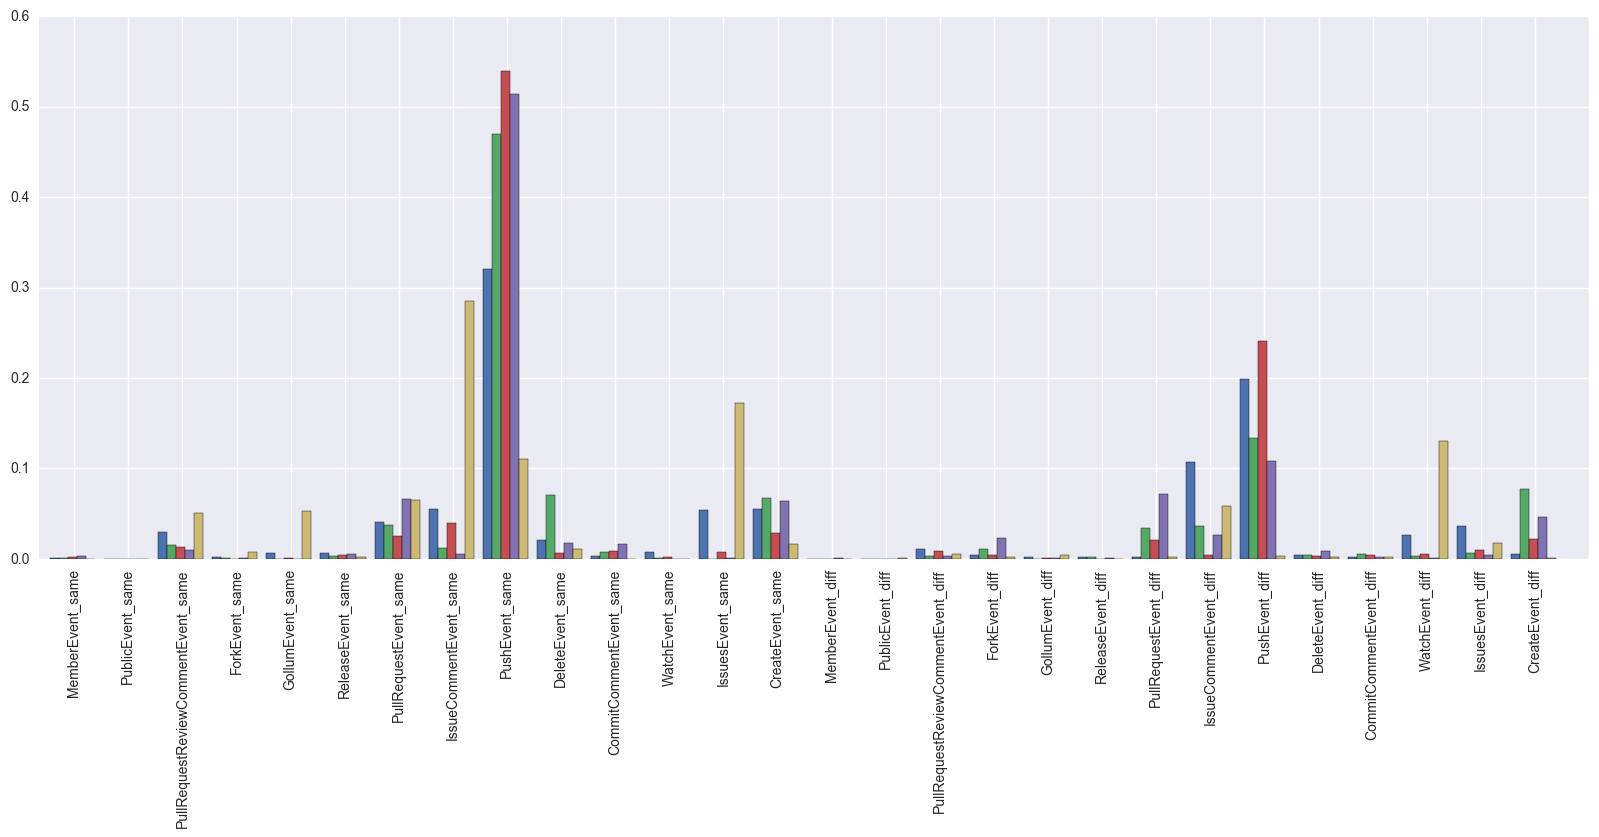

In [28]:
sns.set_style('whitegrid')
sns.set_context('talk')

xcoords = np.arange(28)
plt.figure(figsize=(20,7))
ax = plt.subplot(111)
xcoord = .3
colors = sns.color_palette()
for n in range(n_components):
    ax.bar(xcoords - xcoord + n*1./(n_components+1), model.emissionprob_[n], width = 1./(n_components+1), color=colors[n])
ax.set_xticklabels(label_encodings, rotation='vertical')

plt.xlim([-.5,28])
plt.xticks(np.arange(0,29)+.15)

plt.show()


In [131]:
from sklearn.externals import joblib
joblib.dump(model, 'cluster_model.pkl')

['cluster_model.pkl']

In [22]:
hidden_states = model.predict(np.atleast_2d(X).T)

In [23]:
i = 0
states_split = []
for l in lens:
    states_split.append([hidden_states[i:i+l]])
    i += l
states_split= [l[0] for l in states_split]

In [24]:
from collections import Counter
state_props = []
for u in states_split:
    c = Counter(u)
    sp = [float(c[i])/sum(c.values()) for i in range(n_components)]
    state_props.append(sp)

In [29]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2)
tsne = model.fit_transform(state_props)


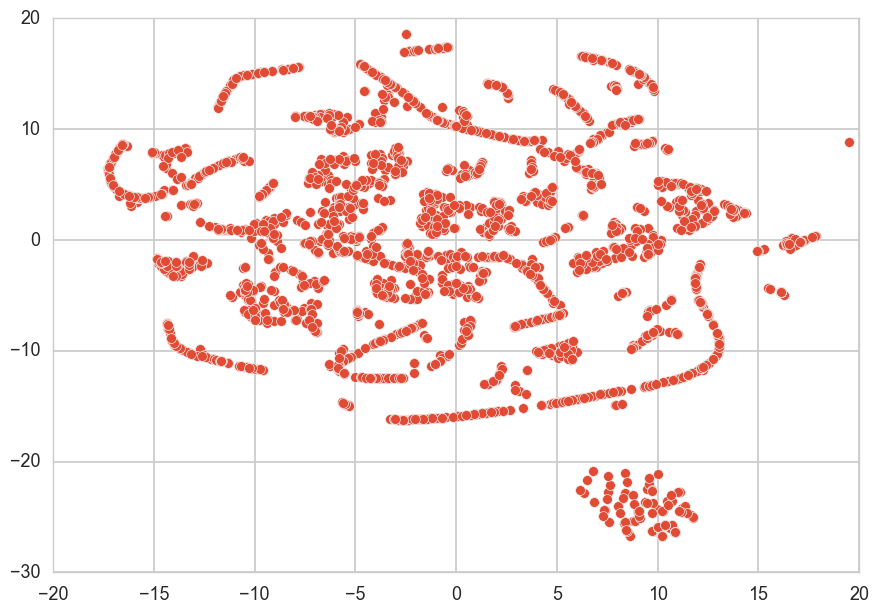

In [78]:
colors = sns.color_palette()

plt.style.use('ggplot')
sns.set_style('whitegrid')
plt.scatter(*zip(*tsne),marker="o", s=50, c=colors[0])
plt.xlim([-20,20])
plt.ylim([-30,20])
plt.show()


In [40]:
ball_ind = [i for (i,t) in enumerate(tsne) if 5 < t[0]< 15 and -30 < t[1] < -20]

In [42]:
ball_data = [hmmdata[i] for i in ball_ind]

In [43]:
ball_counter = Counter(sum(ball_data, []))
ball_tuples = []
for k in range(len(label_encodings)):
    ball_tuples.append((k,ball_counter[k]))
ball_freqs = [float(b)/sum(ball_counter.values()) for (a,b) in ball_tuples]

all_counter = Counter(sum(hmmdata, []))
all_tuples = []
for k in range(len(label_encodings)):
    all_tuples.append((k,all_counter[k]))
all_freqs = [float(b)/sum(all_counter.values()) for (a,b) in all_tuples]

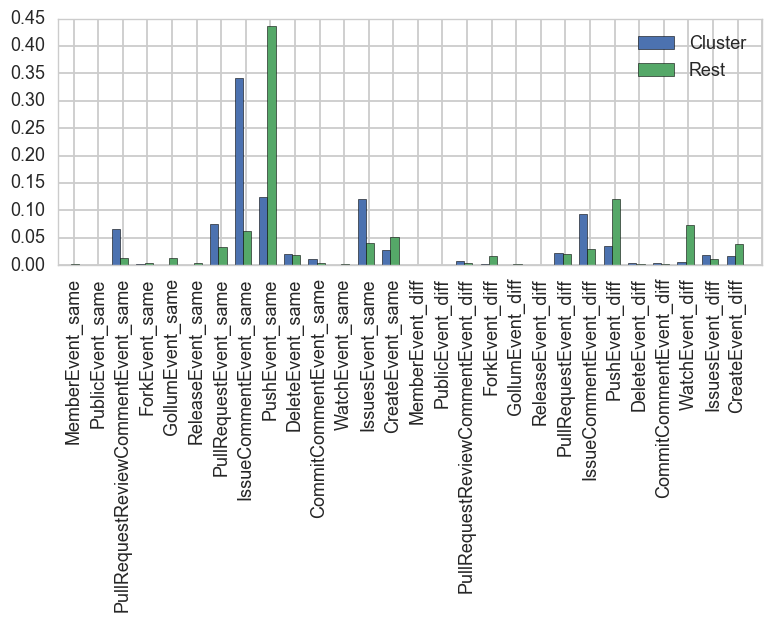

In [48]:
plot_data = [ball_freqs, all_freqs]
labels = ['Cluster', 'Rest']
xcoords = np.arange(28)
plt.figure(figsize=(20,7))
ax = plt.subplot(222)
xcoord = .3
colors = sns.color_palette()
for n in range(2):
    ax.bar(xcoords - xcoord + n*1./(2+1), plot_data[n], width = 1./(2+1), color=colors[n], label=labels[n])
ax.set_xticklabels(label_encodings, rotation='vertical')

plt.xlim([-.5,28])
plt.xticks(np.arange(0,29)+.15)
plt.legend()
plt.show()

In [79]:
output_freqs = []
for u in hmmdata:
    u_counter = Counter(u)
    u_tuple = []
    for k in range(len(label_encodings)):
        u_tuple.append((k,u_counter[k]))
    u_freqs = [float(b)/sum(u_counter.values()) for (a,b) in u_tuple]
    output_freqs.append(u_freqs)

In [80]:
from sklearn.decomposition import PCA
model_output = PCA(n_components=2)
pca_output = model_output.fit_transform(output_freqs)

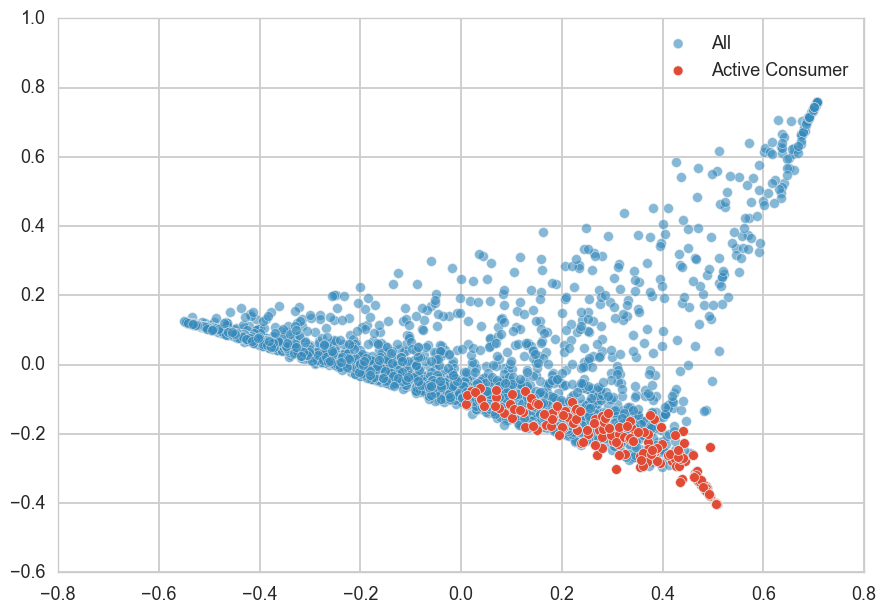

In [94]:
plt.figure()
plt.scatter(*zip(*pca_output),s=50, label='All', c=colors[1],alpha=.6)
plt.scatter(*zip(*[pca_output[i] for i in ball_ind]), s=50, label='Active Consumer', c=colors[0])
plt.legend()